In [1]:
import pandas as pd
import jieba as jb
from sklearn.externals import joblib
import numpy as np


D:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
qa_corpus = pd.read_csv('./qa_corpus.csv')

In [7]:
qa_corpus.head()

,qid,question,answer
0,1,补发网银盾,您可以到智慧柜员机办理此项业务，方便快捷，节省您的宝贵时间哦。若去柜台办理，请刷身份证取号。
1,2,代发工资,您要办理的是对公开户、销户、签约及其他业务。请刷身份证，小龙人来帮您取个号吧。
2,3,对帐单查询打印,您要办理的是对公开户、销户、签约及其他业务。请刷身份证，小龙人来帮您取个号吧。
3,4,理财产品取号,请说出您需要办理的业务
4,5,密码修改,请您带上身份证到自助柜员机办理，简单快捷，操作容易哦。


In [8]:
len(qa_corpus)

32526

In [9]:
qa_corpus['question']

0          补发网银盾
1           代发工资
2        对帐单查询打印
3         理财产品取号
4           密码修改
          ...   
32521      我要点咖啡
32522      帮忙点咖啡
32523        问题1
32524       1111
32525       2222
Name: question, Length: 32526, dtype: object

+ 对quest和answer做预处理，求词向量和句向量

In [10]:
import cut_sentence as cs

all_sentence = []
for idx in range(len(qa_corpus)):
    q = qa_corpus['question'][idx]
    if isinstance(q,str):
        question = cs.segment(q,'arr')
        all_sentence.append(question)
    a = qa_corpus['answer'][idx]
    if isinstance(a,str):
        answer = cs.segment(a,'arr')
        all_sentence.append(answer)


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\webberg\AppData\Local\Temp\jieba.cache
Loading model cost 0.742 seconds.
Prefix dict has been built succesfully.


In [11]:
# 用fastText求所有的词向量
from gensim.models import FastText

model = FastText(all_sentence,size=4, window=3, min_count=1, iter=10,min_n = 3 , max_n = 6,word_ngrams = 0)

In [36]:
# 做句向量
X_sentences= []
new_sentences = []
for idx in range(len(all_sentence)):
    sentence = all_sentence[idx]
    if len(sentence)>0:
        vec = sum([model.wv[word] for word in sentence])/len(sentence)
        X_sentences.append(vec)
        new_sentences.append(sentence)

## 意图识别

#### 意图识别的目标是将问题分类
+ 先对语料库中的问题进行聚类

In [8]:
# K-means的K能否用随机行走的方式来得到？
# 随机从一个点出发，寻找离这个点最近距离的点，然后移动到最近点，接着从这个点继续移动到下一个最近点，这条路径记为L；
# 寻找一个合适的K，使得K个团的L总和最小，并且每个K团之间的距离最大（尽可能分开）

In [46]:
# 使用K-mean聚类
from sklearn.cluster import KMeans

n_clusters = 5
kmean = KMeans(n_clusters=n_clusters)
kmean.fit(X_sentences)
print("kmean: k={}, cost={}".format(n_clusters, int(kmean.score(X_sentences))))

kmean: k=5, cost=-190973


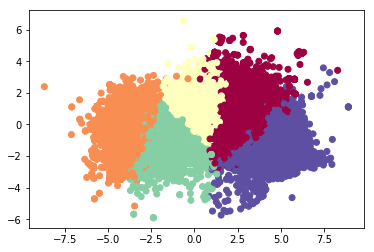

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

labels = kmean.labels_
centers = kmean.cluster_centers_
X_plot = np.array(X_sentences)
pca = PCA(n_components=2)   #降到2维
pca.fit(X_plot)                  #训练
newX=pca.fit_transform(X_plot)   #降维后的数据

fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.gca()
ax.scatter(newX[:, 0], newX[:, 1], c=labels, cmap=plt.cm.Spectral)
plt.show()

In [3]:
# 测试一下，输入句子属于哪一类
input = '你好'
x_quest = cs.segment(input,'arr')
x_vec = sum([model.wv[word] for word in x_quest])/len(x_quest)

kmean.predict([x_vec])

NameError: name 'cs' is not defined

In [55]:
joblib.dump(kmean , 'km.pkl')

['km.pkl']

## 语义相似度判断

In [14]:
kmean = joblib.load('km.pkl')
print(kmean.labels_)

[0 0 0 ... 2 2 2]


In [3]:

def get_class(model,sentence):
    return model.predict([vectorize(sentence)])

In [29]:
from sklearn.neighbors import KDTree

class DataSpace():
    def __init__(self,classes_data):
        '''
        构建KD树
        '''
        points = len(classes_data)
        leaf = points/2-1
        self.tree = KDTree(classes_data,leaf)
        
    def __vectorize__(self,sentence):
        x_quest = cs.segment(sentence,'arr')
        return [sum([model.wv[word] for word in x_quest])/len(x_quest)]
    
    def similarity(self,sentence,topk=10):
        '''
        从KD树中找到最相似的k个数据
        '''
        v = self.__vectorize__(sentence)
        dist, ind = self.tree.query(v,k=topk)
        return (dist,ind)

In [30]:
data0 = DataSpace(np.array(X_sentences)[kmean.labels_==0])
sentence1 = np.array(new_sentences)[kmean.labels_==0]
data1 = DataSpace(np.array(X_sentences)[kmean.labels_==1])
sentence2 = np.array(new_sentences)[kmean.labels_==1]
data2 = DataSpace(np.array(X_sentences)[kmean.labels_==2])
sentence3 = np.array(new_sentences)[kmean.labels_==2]
data3 = DataSpace(np.array(X_sentences)[kmean.labels_==3])
sentence4 = np.array(new_sentences)[kmean.labels_==3]
data4 = DataSpace(np.array(X_sentences)[kmean.labels_==4])
sentence5 = np.array(new_sentences)[kmean.labels_==4]

In [38]:
_,ind = data2.similarity('你好')
sentence3[ind]

array([[list(['你好', '哎']), list(['你好', '任性']), list(['萌萌', '萌萌']),
        list(['宝宝']), list(['叫', '天天', '不灵']), list(['叫', '天天', '不灵']),
        list(['祝', '大家', '新年快乐']),
        list(['真', '动听', '呀', '简直', '就是', '天籁', '之音']),
        list(['祝', '大家', '圣诞快乐']), list(['本', '宝宝', '今年', '三岁', '啦'])]],
      dtype=object)

## 布尔搜索